# Preparing data as Images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch
import os
from pathlib import Path
os.chdir(Path(os.path.abspath("/home/monty/Desktop/DL Project/DeepLearning_group_2/mros-data-main/mros_data")))
from mros_data.datamodule import SleepEventDataModule
from mros_data.datamodule.transforms import STFTTransform
from matplotlib import patches
import json

Using this method to convert spectograms into Images

In [2]:
def spectogram_to_image(signals):

    ch_mix = abs(signals[0] - signals[1])
    signals = np.append(signals, [ch_mix], axis=0)

    spectrogram = np.dstack([signals[0],signals[1],signals[2]])

    tensor= torch.tensor(spectrogram)*255
    tensor = np.array(tensor, dtype=np.uint8)

    return Image.fromarray((tensor).astype(np.uint8))

and using this method we make folder with eval and train set of images

In [3]:
def SaveImagesToFolder(train_ds,eval_ds):
    len_train = len(train_ds)
    len_eval = len(eval_ds)

    img_path = "/home/monty/Desktop/DL Project/DeepLearning_group_2/coco5"

    if os.path.isdir(img_path) == False:
        os.mkdir(img_path)
        os.mkdir(f"{img_path}/train")
        os.mkdir(f"{img_path}/eval")
        os.mkdir(f"{img_path}/annotations")

    for x in range(len_train):
        img = spectogram_to_image(train_ds[x]["signal"])

        img_name = f"train_{x}.png"
        image = img.save(f"{img_path}/train/{img_name}")

    for x in range(len_eval):
        img = spectogram_to_image(eval_ds[x]["signal"])

        img_name = f"eval_{x}.png"
        image = img.save(f"{img_path}/eval/{img_name}")

Preparing dataset

In [4]:
params = dict(
    data_dir="/home/monty/Desktop/DL Project/DeepLearning_group_2/lm/",
    batch_size=16,
    n_eval=2,
    n_test=2,
    num_workers=0,
    seed=1337,
    events={"lm": "Leg movement"},
    window_duration=600,  # seconds
    cache_data=True,
    default_event_window_duration=[15],
    event_buffer_duration=3,
    factor_overlap=2,
    fs=64,
    matching_overlap=0.5,
    n_jobs=-1,
    n_records=10,
    picks=["legl", "legr"],
    # transform=MultitaperTransform(128, 0.5, 35.0, tw=8.0, normalize=True),
    transform=STFTTransform(
        fs=64, segment_size=int(4.0 * 64), step_size=int(0.125 * 64), nfft=1024, normalize=True
    ),
    scaling="robust",
)
dm = SleepEventDataModule(**params)

In [5]:
dm.setup('fit')
train_ds = dm.train
eval_ds = dm.eval

Using cache for data prep: /home/monty/Desktop/DL Project/DeepLearning_group_2/mros-data-main/mros_data/data/.cache


100%|██████████| 6/6 [00:00<00:00, 39.52it/s]


Using cache for data prep: /home/monty/Desktop/DL Project/DeepLearning_group_2/mros-data-main/mros_data/data/.cache


100%|██████████| 2/2 [00:00<00:00, 2160.34it/s]


Converting a signal to spectogram image

In [6]:
data_loader_train = dm.train_dataloader()
data_loader_val = dm.val_dataloader()

2DMatrix is here


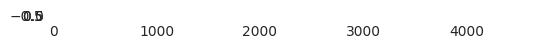

In [7]:
spectrogram = train_ds.get_2Dmatrix(0, channel_idx=0, window_size=int(4.0 * train_ds.fs), step_size=int(0.125 * train_ds.fs), nfft=1024)
IMG = spectogram_to_image(spectrogram)
imgplot = plt.imshow(IMG)

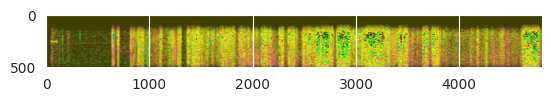

In [8]:
IMG2 = spectogram_to_image(train_ds[0]["signal"])

imgplot2 = plt.imshow(IMG2)

Now creating the image folders and files

In [ ]:
SaveImagesToFolder(train_ds,eval_ds)

In [15]:
def PlotImageWithBoxes(image,events):
    _events = np.delete(events, 2, 1)*image.width
    fig, ax = plt.subplots()
    for i in range(len(_events)):
        x = _events[i,1]
        y = 0
        width = _events[i,1] - _events[i,0]
        height = IMG.height
        bbox = (x, y, width, height)
        bb = patches.Rectangle((bbox[0],bbox[1]), bbox[2],bbox[3], linewidth=1, edgecolor="green", facecolor="none")
        ax.add_patch(bb)

    ax.imshow(image)
    plt.show()

Now let us create the annotation file

In [42]:
def AddAnnotations(res_file,Start,End,Height,annot_count,image_id):
    xmin = Start
    ymin = 0
    xmax = End
    ymax = Height
    w = End-Start
    h = Height
    area = w * h
    poly = [[xmin, ymin],
            [xmax, ymin],
            [xmax, ymax],
            [xmin, ymax]]

    annot_elem = {
        "id": annot_count,
        "bbox": [
            float(xmin),
            float(ymin),
            float(w),
            float(h)
        ],
        "segmentation": list([poly]),
        "image_id": image_id,
        "ignore": 0,
        "category_id": 0,
        "iscrowd": 0,
        "area": float(area)
    }
    res_file["annotations"].append(annot_elem)

In [47]:
def AddImage(res_file,img,events,annot_count, image_id,isTrain):

    if isTrain:
        path = f"/content/gdrive/MyDrive/coco5/train/train_{image_id}.png"
    else:
        path = f"/content/gdrive/MyDrive/coco5/eval/eval_{image_id}.png"

    img_w, img_h = img.size
    img_elem = {"file_name": f"{path}",
                "height": img_h,
                "width": img_w,
                "id": image_id}
    for elm in range(len(events)):
        AddAnnotations(res_file,float(events[elm,0]),float(events[elm,1]),img_h,annot_count,image_id)
        annot_count += 1
    res_file["images"].append(img_elem)
    return annot_count

In [48]:
def CreateAnnotationFile(train_ds,eval_ds):
    len_train = len(train_ds)
    len_eval = len(eval_ds)

    json_path = "/home/monty/Desktop/DL Project/DeepLearning_group_2/coco5/annotations"

    categories = [
    {
        "supercategory": "none",
        "name": "movement",
        "id": 0
    }]

    res_file = {
        "categories": categories,
        "images": [],
        "annotations": []
    }
    annot_count = 0
    image_id = 0
    json_file = "instances_train2017.json"

    for x in range(len_train):
        spectrogram = train_ds.get_2Dmatrix(x, channel_idx=0, window_size=int(4.0 * train_ds.fs),
                                            step_size=int(0.125 * train_ds.fs), nfft=1024)
        img = spectogram_to_image(spectrogram)
        events = train_ds[x]['events']
        annot_count = AddImage(res_file,img,events,annot_count, image_id,True)
        image_id += 1
        #print("\tProcessed {}/{} images.".format(image_id,len_train))

    with open(os.path.join(json_path,json_file), "w") as f:
        json_str = json.dumps(res_file)
        f.write(json_str)

    print("Processed {} train images...".format(image_id))

    categories = [
    {
        "supercategory": "none",
        "name": "movement",
        "id": 0
    }]

    res_file = {
        "categories": categories,
        "images": [],
        "annotations": []
    }
    annot_count = 0
    image_id = 0
    json_file = "instances_val2017.json"

    for x in range(len_eval):
        spectrogram = eval_ds.get_2Dmatrix(x, channel_idx=0, window_size=int(4.0 * train_ds.fs),
                                            step_size=int(0.125 * train_ds.fs), nfft=1024)
        img = spectogram_to_image(spectrogram)
        events = train_ds[x]['events']
        annot_count = AddImage(res_file,img,events,annot_count, image_id,False)
        image_id += 1
        #print("\tProcessed {}/{} images.".format(image_id,len_eval))

    with open(os.path.join(json_path,json_file), "w") as f:
        json_str = json.dumps(res_file)
        f.write(json_str)
    print("Processed {} eval images...".format(image_id))

    print("Done.")

In [50]:
CreateAnnotationFile(train_ds,eval_ds)

Processed 700 train images...
Processed 280 eval images...
Done.
